In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#    -O /tmp/daily-min-temperatures.csv

In [4]:
import pandas as pd
df = pd.read_csv('DATA_FULL.csv')

In [5]:
# Definining Subdata
series = df.Beras.values       #y-axis (data)
time = df.Date.values          #x-axis (timestamps)
df.head()

,Date,Beras,Daging Ayam,Daging Sapi,Telur Ayam,Bawang Merah,Bawang Putih,Cabai Merah,Cabai Rawit,Minyak Goreng,Gula Pasir
0,2016-07-01,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0
1,2016-07-02,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0
2,2016-07-03,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0
3,2016-07-04,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0
4,2016-07-05,11550.0,40000.0,121100.0,25450.0,45300.0,43150.0,32600.0,40250.0,14200.0,17800.0


In [6]:
train_size = 0.9
split_time = int(train_size*len(df))

time_train = df.Date[:split_time].values
x_train = df.Beras[:split_time].values

time_valid = df.Date[split_time:].values
x_valid = df.Beras[split_time:].values

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1286,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

In [21]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

time_callback = TimeHistory()

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, time_callback])


Epoch 1/100
5/5 [==============================] - 4s 730ms/step - loss: 11509.5302 - mae: 11508.7578
Epoch 2/100
5/5 [==============================] - 1s 238ms/step - loss: 11508.1600 - mae: 11508.2109
Epoch 3/100
5/5 [==============================] - 1s 245ms/step - loss: 11506.3421 - mae: 11507.2656
Epoch 4/100
5/5 [==============================] - 1s 222ms/step - loss: 11505.1183 - mae: 11506.0674
Epoch 5/100
5/5 [==============================] - 1s 242ms/step - loss: 11503.9682 - mae: 11504.6309
Epoch 6/100
5/5 [==============================] - 1s 217ms/step - loss: 11502.1984 - mae: 11502.9121
Epoch 7/100
5/5 [==============================] - 1s 233ms/step - loss: 11499.6992 - mae: 11500.8291
Epoch 8/100
5/5 [==============================] - 1s 230ms/step - loss: 11498.5261 - mae: 11498.2256
Epoch 9/100
5/5 [==============================] - 1s 235ms/step - loss: 11495.0728 - mae: 11495.0986
Epoch 10/100
5/5 [==============================] - 1s 223ms/step - loss: 11491.55

5/5 [==============================] - 1s 285ms/step - loss: 2124.1939 - mae: 2127.3152
Epoch 82/100
5/5 [==============================] - 1s 262ms/step - loss: 1235.3978 - mae: 1220.2872
Epoch 83/100
5/5 [==============================] - 1s 262ms/step - loss: 1443.9154 - mae: 1485.5652
Epoch 84/100
5/5 [==============================] - 1s 240ms/step - loss: 713.0821 - mae: 707.9836
Epoch 85/100
5/5 [==============================] - 2s 348ms/step - loss: 645.2864 - mae: 644.4296
Epoch 86/100
5/5 [==============================] - 2s 320ms/step - loss: 713.4060 - mae: 722.3597
Epoch 87/100
5/5 [==============================] - 2s 307ms/step - loss: 730.3645 - mae: 705.8525
Epoch 88/100
5/5 [==============================] - 1s 267ms/step - loss: 841.7663 - mae: 839.2379
Epoch 89/100
5/5 [==============================] - 1s 244ms/step - loss: 1190.8138 - mae: 1218.9026
Epoch 90/100
5/5 [==============================] - 2s 311ms/step - loss: 3102.4599 - mae: 3038.5820
Epoch 91/100


In [28]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

total time fitting (approx.): 135.41 s


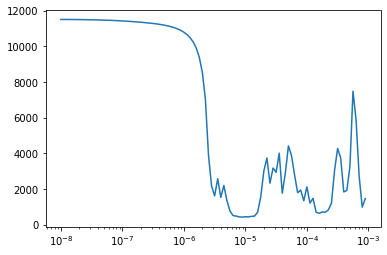

In [30]:
plt.semilogx(history.history["lr"], history.history["loss"]);
#plt.axis([1e-8, 1e-4, 0, 60]);

## Conv1D + LSTM (2 layers)  

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, 
                             shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [32]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

time_callback = TimeHistory()

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=150, callbacks=[time_callback])

Epoch 1/150
13/13 [==============================] - 4s 311ms/step - loss: 11403.9417 - mae: 11409.7461
Epoch 2/150
13/13 [==============================] - 2s 173ms/step - loss: 10928.5090 - mae: 10972.5098
Epoch 3/150
13/13 [==============================] - 2s 143ms/step - loss: 5543.7502 - mae: 5766.9077
Epoch 4/150
13/13 [==============================] - 2s 155ms/step - loss: 2108.6600 - mae: 2096.0293
Epoch 5/150
13/13 [==============================] - 2s 138ms/step - loss: 1584.5381 - mae: 1553.6654
Epoch 6/150
13/13 [==============================] - 2s 154ms/step - loss: 1196.2486 - mae: 1215.3456
Epoch 7/150
13/13 [==============================] - 2s 145ms/step - loss: 607.9581 - mae: 615.8384
Epoch 8/150
13/13 [==============================] - 2s 148ms/step - loss: 553.5494 - mae: 559.7965
Epoch 9/150
13/13 [==============================] - 2s 147ms/step - loss: 498.4277 - mae: 494.9511
Epoch 10/150
13/13 [==============================] - 2s 156ms/step - loss: 396.6925

13/13 [==============================] - 2s 188ms/step - loss: 483.1461 - mae: 488.9186
Epoch 83/150
13/13 [==============================] - 3s 228ms/step - loss: 379.2723 - mae: 383.6083
Epoch 84/150
13/13 [==============================] - 2s 167ms/step - loss: 314.4417 - mae: 317.6584
Epoch 85/150
13/13 [==============================] - 2s 168ms/step - loss: 329.9796 - mae: 320.2971
Epoch 86/150
13/13 [==============================] - 2s 185ms/step - loss: 341.7376 - mae: 345.3879
Epoch 87/150
13/13 [==============================] - 2s 153ms/step - loss: 442.6436 - mae: 442.0824
Epoch 88/150
13/13 [==============================] - 3s 218ms/step - loss: 402.4751 - mae: 404.1965
Epoch 89/150
13/13 [==============================] - 3s 220ms/step - loss: 383.4409 - mae: 386.2267
Epoch 90/150
13/13 [==============================] - 2s 150ms/step - loss: 359.1592 - mae: 364.4049
Epoch 91/150
13/13 [==============================] - 2s 185ms/step - loss: 376.5449 - mae: 370.4689
Epo

In [34]:
print("total time fitting (approx.): {:.2f} s".format(sum(time_callback.times)))

total time fitting (approx.): 310.09 s


In [35]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

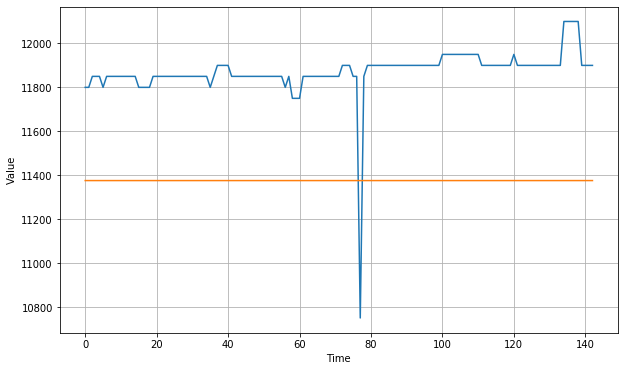

In [37]:
plt.figure(figsize=(10, 6))

time_step = np.arange(len(time_valid))

plot_series(time_step, x_valid)
plot_series(time_step, rnn_forecast)

In [38]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

506.24432

In [39]:
print(rnn_forecast)

[11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582 11375.582
 11375